<a href="https://colab.research.google.com/github/tolerant-code/Deep-Learning-Project/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Project**

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import librosa.display
import librosa
from PIL import Image

In [26]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
GTZAN = "/content/drive/MyDrive/Colab Notebooks/GTZAN"

In [22]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

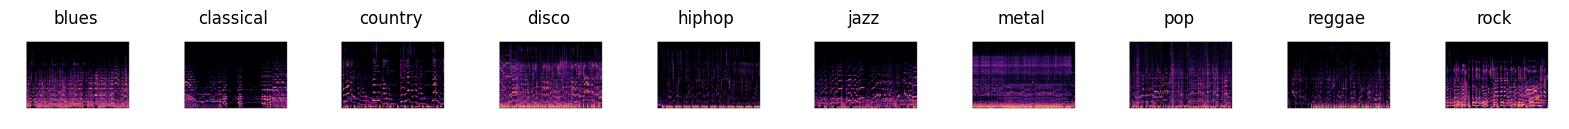

In [29]:
# Visualize Some Image in the GTZAN dataset
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))
for i in range(len(genres)):
    genre_path = os.path.join(GTZAN, genres[i])
    image_path = os.path.join(genre_path, os.listdir(genre_path)[0])
    image = Image.open(image_path)
    axs[i].imshow(image)
    axs[i].set_title(genres[i])
    axs[i].axis('off')
plt.show()

In [23]:
# Define empty lists for images and labels
X = []
y = []

# Loop through each genre directory
for genre in genres:
    genre_dir = os.path.join(GTZAN, genre)

    # Loop through each PNG file in genre directory
    for file_name in os.listdir(genre_dir):
        if file_name.endswith('.png'):
            file_path = os.path.join(genre_dir, file_name)

            # Load PNG image and resize to fixed shape
            image = Image.open(file_path).resize((224, 224))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            # Convert image to numpy array and normalize pixel values
            image = np.array(image) / 255.0

            # Append image and label to X and y lists
            X.append(image)
            y.append(genres.index(genre))

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

In [24]:
# One-hot encode labels
y = tf.keras.utils.to_categorical(y, num_classes=len(genres))

# Split dataset into training and validation sets
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(genres), activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

(719, 224, 224, 3)
(200, 224, 224, 3)
(80, 224, 224, 3)
Epoch 1/10
23/23 [==============================] - 4s 100ms/step - loss: 2.4702 - accuracy: 0.1099 - val_loss: 2.2786 - val_accuracy: 0.1375
Epoch 2/10
23/23 [==============================] - 1s 56ms/step - loss: 2.2315 - accuracy: 0.1878 - val_loss: 2.1167 - val_accuracy: 0.2500
Epoch 3/10
23/23 [==============================] - 1s 53ms/step - loss: 2.0544 - accuracy: 0.2809 - val_loss: 1.7713 - val_accuracy: 0.4250
Epoch 4/10
23/23 [==============================] - 1s 52ms/step - loss: 1.7899 - accuracy: 0.3797 - val_loss: 1.4570 - val_accuracy: 0.5000
Epoch 5/10
23/23 [==============================] - 1s 58ms/step - loss: 1.6292 - accuracy: 0.4228 - val_loss: 1.4181 - val_accuracy: 0.5875
Epoch 6/10
23/23 [==============================] - 1s 56ms/step - loss: 1.4907 - accuracy: 0.4965 - val_loss: 1.0804 - val_accuracy: 0.6625
Epoch 7/10
23/23 [==============================] - 1s 65ms/step - loss: 1.2424 - accuracy: 0.564

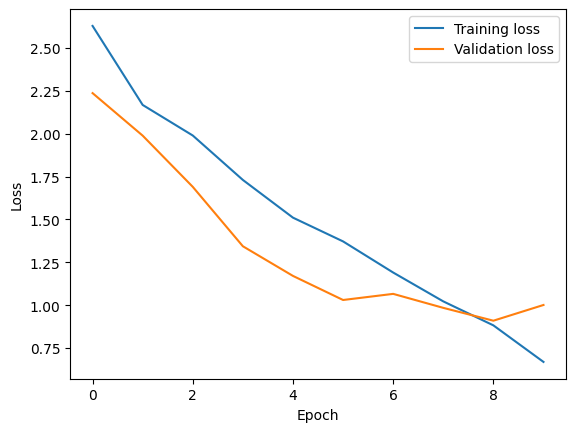

In [8]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

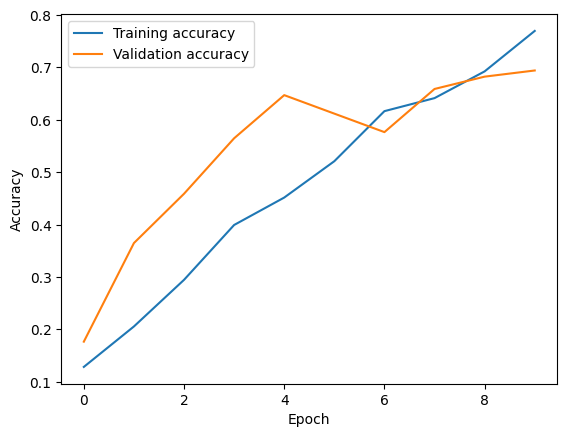

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

5/5 [==============================] - 0s 18ms/step


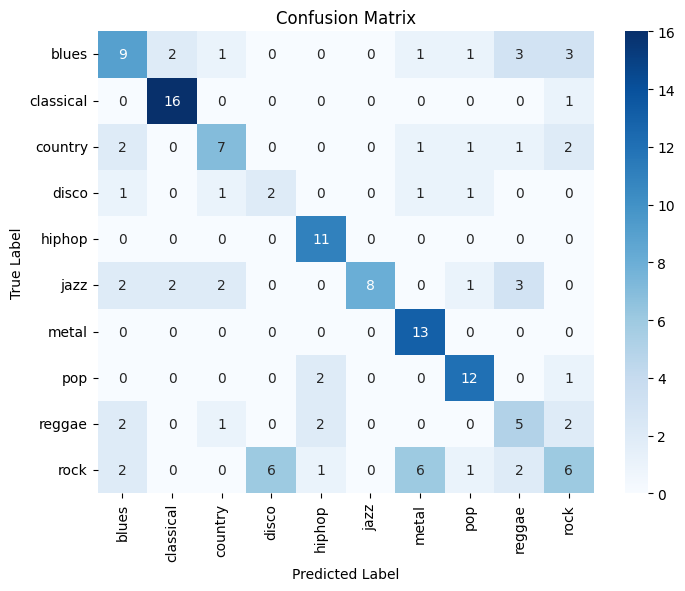

In [15]:
# Predict probabilities for each class
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_probs = model.predict(X_test)

# Convert probabilities to class labels
y_preds = np.argmax(y_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=genres, yticklabels=genres, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
from sklearn.metrics import classification_report

y_probs = model.predict(X_test)

# Convert probabilities to class labels
y_preds = np.argmax(y_probs, axis=1)

# Print classification report
print(classification_report(np.argmax(y_test, axis=1), y_preds, target_names=genres))

5/5 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

       blues       0.50      0.45      0.47        20
   classical       0.80      0.94      0.86        17
     country       0.58      0.50      0.54        14
       disco       0.25      0.33      0.29         6
      hiphop       0.69      1.00      0.81        11
        jazz       1.00      0.44      0.62        18
       metal       0.59      1.00      0.74        13
         pop       0.71      0.80      0.75        15
      reggae       0.36      0.42      0.38        12
        rock       0.40      0.25      0.31        24

    accuracy                           0.59       150
   macro avg       0.59      0.61      0.58       150
weighted avg       0.61      0.59      0.58       150



5/5 [==============================] - 0s 18ms/step


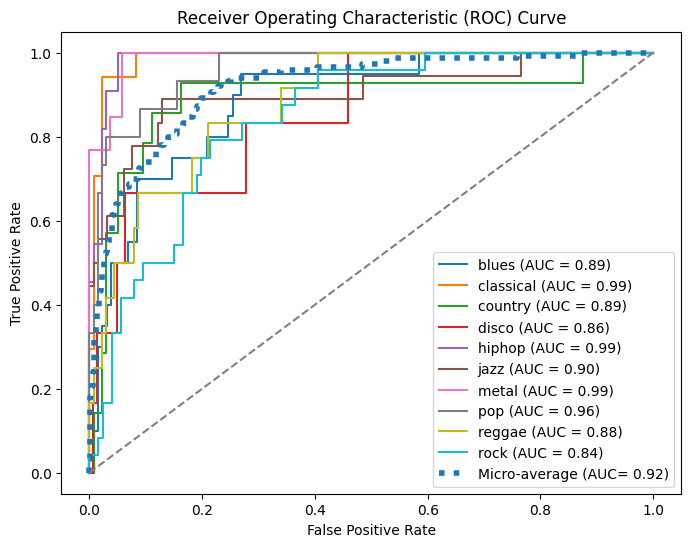

In [10]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for each class
y_probs = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(genres)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(genres)):
    plt.plot(fpr[i], tpr[i], label=f'{genres[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC= {roc_auc_micro:.2f})', linestyle=':', linewidth=4)

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Set plot title and labels
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Show plot
plt.show()